# Final Project

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from helper import get_train_test, lowercase, tokenize, remove_punctuation, remove_stopwords, \
    remove_non_letters, stemming, correct_spelling, reduce_lengthening, subsampling, save_preprocessed_data, \
    get_categories, get_train_test_data, get_label_encoder
    
config = {
    'lowercase': True,
    'stemming': True,
    'remove_stopwords': True,
    'remove_non_letters': True,
    'remove_punctuation': True,
    'correct_spelling': True,
    'reduce_lengthening': True,
    'subsampling': False,
    'use_checkpoint':True
}


## Preprocessing

In [4]:
if not config['use_checkpoint']:
    train, test = get_train_test_data('train_data.txt', 'test_data.txt')

    # subsampling
    if config['subsampling']:
        subsampling(train)
        subsampling(test)

    # lowercasing
    if config['lowercase']:
        lowercase(train)
        lowercase(test)

    # removing non letters
    if config['remove_non_letters']:
        remove_non_letters(train)
        remove_non_letters(test)

    # removing punctuation
    if config['remove_punctuation']:
        remove_punctuation(train)
        remove_punctuation(test)

    # tokenizing
    tokenize(train)
    tokenize(test)

    # reducing length
    if config['reduce_lengthening']:
        reduce_lengthening(train)
        reduce_lengthening(test)

    # correcting spelling
    if config['correct_spelling']:
        correct_spelling(train)
        correct_spelling(test)

    # removing stopwords
    if config['remove_stopwords']:
        remove_stopwords(train)
        remove_stopwords(test)

    # stemming
    if config['stemming']:
        stemming(train)
        stemming(test)

    # saving preprocessed data
    save_preprocessed_data(train, 'train_data.pkl')
    save_preprocessed_data(test, 'test_data.pkl')

## Checkpoint

In [ ]:
from helper import load_preprocessed_data

train, test = load_preprocessed_data('train_data.pkl', 'test_data.pkl')

# Statistics

In [6]:
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

# 1.a Categories frequency

In [7]:
category_counts = pd.value_counts(train['category'])
pd.DataFrame(category_counts,columns=['Counts'])

,Counts
Entertainment,2853
Relationships,2381
Culture,1685
Health,1501
Computers,1396
Science,1078
Education,896
Politics,888
Business,731
Style,667


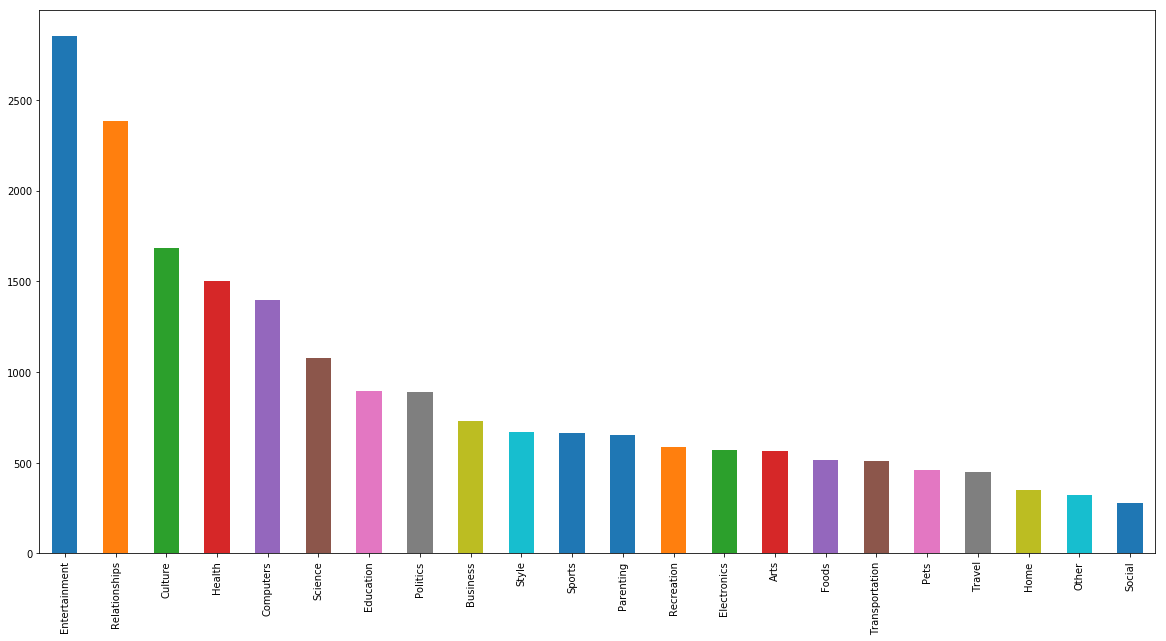

In [8]:
category_counts.sort_values(ascending=False).plot(kind='bar',figsize=(20,10))

# 1.b Avarage sentence length per category

In [9]:
train_df['sentence_length'] = train_df.apply(lambda x: len(x['content']) + len(x['subject']),axis=1)

In [10]:
train_df.groupby(train_df.category).mean().astype('int')

,sentence_length
category,
Arts,17
Business,21
Computers,19
Culture,21
Education,16
Electronics,17
Entertainment,17
Foods,14
Health,21


# 1.c percentage of empty-content samples per catgeory

In [11]:
empty_content_percent = train_df.where(train_df.content.str.len() == 0).dropna().groupby(train_df.category).size() / \
train_df.groupby(train_df.category).size() * 100
pd.DataFrame(empty_content_percent,columns=['Percent'])

,Percent
category,
Arts,36.234458
Business,32.694938
Computers,29.656160
Culture,30.919881
Education,36.272321
Electronics,31.634446
Entertainment,32.562215
Foods,38.565891
Health,28.514324


# 1.d number of unique words, and number of total words

In [12]:
num_overall_words = train_df['sentence_length'].sum()
print("Number of overall words: {}".format(num_overall_words))

Number of overall words: 414994


In [13]:
num_unique_words = len(set(reduce(set.union , [set(x) for x in train_df['content'].tolist()])).union(reduce(set.union , [set(x) for x in train_df['subject'].tolist()])))

print("Number of unique words: {}".format(num_unique_words))

Number of unique words: 19801


## Classifications

### Nearest Centroid

In [14]:
categories = get_categories('categories.txt')
label_encoder = get_label_encoder(categories)
X_train, y_train, X_test = get_train_test(train, test, label_encoder)

In [15]:
def compute_min_centroid(x,centroids):
    min_d = np.inf
    min_cat = -1
    for k,v in centroids.iteritems():
        d = euclidean(x,v)
        if d < min_d:
            min_d = d
            min_cat = k
    return min_cat

# Training and cross validating

In [21]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3,shuffle=True)
kf.get_n_splits(train_df)
best_count_vect = {}
best_tfidf_transfomer = {}
best_centroids = {}
best_val_accuracy = -np.inf
fold_ind=1

for train_index, val_index in kf.split(train_df):
    #split for train and val
    X_train_split, X_val_split = np.asarray(X_train)[train_index].tolist(), np.asarray(X_train)[val_index].tolist()
    
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train_split)
    X_val_counts = count_vect.transform(X_val_split)
    
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_val_tfidf = tfidf_transformer.transform(X_val_counts)
    
    train_df=train_df.astype('object')
    train_df.loc[train_index,'tfidf'] = X_train_tfidf.toarray().tolist()
    train_df.loc[val_index,'tfidf'] = X_val_tfidf.toarray().tolist()
    
    train_grouped_categories_tfidf = train_df.iloc[train_index].groupby(train_df.category)['tfidf']
    
    train_centroids = {}
    for n,g in train_grouped_categories_tfidf:
        class_label = label_encoder.transform([str(n)])[0]
        tfidf_mat = np.array(g.values)
        tfidf_mat = np.stack(tfidf_mat, axis=0)
        train_centroids[class_label] = tfidf_mat.mean(axis=0)
    
    train_df.loc[train_index,'min_centroid'] = train_df.loc[train_index]['tfidf'].apply(lambda x:compute_min_centroid(x,train_centroids))
    train_df.loc[val_index,'min_centroid'] = train_df.loc[val_index]['tfidf'].apply(lambda x:compute_min_centroid(x,train_centroids))
    
    train_predicted_categories = label_encoder.inverse_transform(train_df.iloc[train_index]['min_centroid'].values.astype('int').tolist())
    val_predicted_categories = label_encoder.inverse_transform(train_df.iloc[val_index]['min_centroid'].values.astype('int').tolist())
    
    train_pred_vs_truth = pd.DataFrame(np.vstack((train_df.iloc[train_index]['category'].values,train_predicted_categories))).transpose()
    val_pred_vs_truth = pd.DataFrame(np.vstack((train_df.iloc[val_index]['category'].values,val_predicted_categories))).transpose()
    train_pred_vs_truth.columns = ['truth','pred']
    val_pred_vs_truth.columns = ['truth','pred']
    
    train_accuracy = (len(train_pred_vs_truth.where(train_pred_vs_truth['truth'] == train_pred_vs_truth['pred']).dropna()) / \
            float(len(train_pred_vs_truth))) * 100
    val_accuracy = (len(val_pred_vs_truth.where(val_pred_vs_truth['truth'] == val_pred_vs_truth['pred']).dropna()) / \
            float(len(val_pred_vs_truth))) * 100
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_count_vect = count_vect
        best_tfidf_transfomer = tfidf_transformer
        best_train_centroids = train_centroids
        
    print("Train accuracy: {}%".format(train_accuracy))
    print("Val accuracy for fold {} is: {}%".format(fold_ind,val_accuracy))
    fold_ind = fold_ind + 1

Train accuracy: 62.2740568514%
Val accuracy for fold 1 is: 52.6173691315%
Train accuracy: 63.159078977%
Val accuracy for fold 2 is: 52.6323683816%
Train accuracy: 62.6968651567%
Val accuracy for fold 3 is: 52.400240024%


# Prediction on test set

In [22]:
X_test_counts = best_count_vect.transform(X_test)
X_test_tfidf = best_tfidf_transfomer.transform(X_test_counts)
test_df['tfidf'] = X_test_tfidf.toarray().tolist()
test_df['min_centroid'] = test_df['tfidf'].apply(lambda x:compute_min_centroid(x,best_train_centroids))
test_predicted_categories = label_encoder.inverse_transform(test_df['min_centroid'].values.astype('int').tolist())

In [23]:
with open('output1.txt','wb') as f:
    for pred in test_predicted_categories:
        f.write("{}\n".format(pred))

### LSTM (Deep Learning)

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping
from keras import regularizers
from numpy import argmax
from collections import Counter

hyper_params = {
    'validation_split': 0.01,
    'batch_size': 32,
    'epochs': 3,
    'embedding_size': 1024,
    'keep_probability': 0.5,
    'lstm_size': 32,
    'max_sequence': 100,
    'l2_regularization': 0.01
}

categories = get_categories('categories.txt')
label_encoder = get_label_encoder(categories)
X_train, y_train, X_test = get_train_test(train, test, label_encoder)
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(set(X_train).union(set(X_test)))
train_tokenized = tokenizer.texts_to_sequences(X_train)
test_tokenized = tokenizer.texts_to_sequences(X_test)
X_train = sequence.pad_sequences(train_tokenized, maxlen=hyper_params['max_sequence'])
X_test = sequence.pad_sequences(test_tokenized, maxlen=hyper_params['max_sequence'])
vocab_size = len(Counter([token for sublist in train_tokenized + test_tokenized for token in sublist])) + 1

model = Sequential()
model.add(Embedding(vocab_size, hyper_params['embedding_size']))
model.add(Bidirectional(LSTM(hyper_params['lstm_size'])))
model.add(Dropout(1 - hyper_params['keep_probability']))
model.add(Dense(len(categories), activation='softmax'))          
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.fit(X_train, y_train, batch_size=hyper_params['batch_size'], epochs=hyper_params['epochs'], 
          validation_split=hyper_params['validation_split'], shuffle=True, 
          callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=1)])

predictions = [label_encoder.inverse_transform([argmax(result)])[0] for result in model.predict(X_test)]
output_file = open('output2.txt', 'w')
for item in predictions:
    output_file.write("%s\n" % item)